In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

In [3]:
# ##############################################################################
# ######################################### Plot the results ###################
# ##############################################################################
plt.rcParams['font.size'] = 12
plt.rc('font', weight='bold')
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 17
plt.rcParams['axes.titleweight']='bold'
plt.rcParams['xtick.labelsize'] =13
plt.rcParams['ytick.labelsize'] =13
plt.rcParams['lines.linewidth']=2.0
plt.rcParams['figure.figsize'] = 4,3  #width,height
plt.rcParams['lines.markersize']=15
plt.rcParams['axes.linewidth'] =3

 

plt.rcParams['xtick.major.size']=5
plt.rcParams['xtick.direction']= 'out'
plt.rcParams['xtick.major.width']=2

 

plt.rcParams['ytick.major.size']=5
plt.rcParams['ytick.direction']= 'in'
plt.rcParams['ytick.major.width']=1.0

 

plt.rcParams['xtick.major.pad']='5'
plt.rcParams['ytick.major.pad']='5'

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

xbins = 256
window = 71
poly = 3
outcar_file = 'OUTCAR_ALGB_300K'
label = '300K'
dt_ps = 0.0015  # ps per step

# --- Count MD Steps ---
def count_isteps(filename):
    with open(filename, 'r') as fin:
        return sum(1 for line in fin if line.strip().startswith('E-fermi'))

isteps = count_isteps(outcar_file)
print(f"\nDetected total steps in {outcar_file}: {isteps}\n")

# --- Process OUTCAR to DOS-time file ---
def process_outcar(filename, output_filename):
    xpos = [0.0] * xbins
    xdos = [0.0] * xbins

    def array2dist(ncount, val, xmin, xmax, xbins, xpos, xdos):
        xsudd = (xmax - xmin) / (xbins - 1)
        for i in range(1, ncount + 1):
            npos = int((val[i] - xmin) / xsudd) + 1
            if 0 <= npos - 1 < xbins:
                xdos[npos - 1] += 1.0
        farea = sum(xsudd * d for d in xdos)
        for i in range(xbins):
            xpos[i] = xmin + xsudd * i
            xdos[i] = 1000.0 * xdos[i] / farea if farea != 0 else 0.0

    with open(output_filename, 'w') as fout, open(filename, 'r') as fin:
        nbands = None
        istep = 0
        while True:
            line = fin.readline()
            if not line:
                break
            if 'NBANDS=' in line:
                nbands = int(line.split('NBANDS=')[1].split()[0])
                energy = [0.0] * (nbands + 1)
            if line.strip().startswith('E-fermi') and nbands is not None:
                istep += 1
                efermi = float(line.strip().split()[2])
                for _ in range(8):
                    fin.readline()
                read_bands = 0
                while read_bands < nbands:
                    line = fin.readline()
                    if not line:
                        break
                    parts = line.strip().split()
                    if len(parts) < 2:
                        continue
                    try:
                        iband = int(parts[0])
                        energy[iband - 1] = float(parts[1])
                        read_bands += 1
                    except ValueError:
                        continue
                xdos = [0.0] * xbins
                array2dist(nbands, energy, energy[0], energy[nbands - 1], xbins, xpos, xdos)
                for i in range(xbins):
                    fout.write(f"{istep} {istep * sigma:.3f} {xpos[i] - efermi:.6f} {xdos[i]:.6f}\n")

# --- Process the OUTCAR ---
dat_file = f"dos-time_python_{label}.dat"
process_outcar(outcar_file, dat_file)
print(f"\nProcessed and saved to {dat_file}\n")

# --- Load and prepare plot data ---
data = np.loadtxt(dat_file)
steps = np.unique(data[:, 0]).astype(int)
print(f"Found {len(steps)} time steps in {dat_file}")

# representative steps 
n_steps_to_plot = 5
selected_steps = np.linspace(0, len(steps)-1, n_steps_to_plot, dtype=int)
steps_to_plot = steps[selected_steps]
print(f"\nSteps selected for plotting: {steps_to_plot}\n")




Detected total steps in OUTCAR_ALGB_300K: 5000


Processed and saved to dos-time_python_300K.dat

Found 4999 time steps in dos-time_python_300K.dat

Steps selected for plotting: [   1 1250 2500 3749 4999]



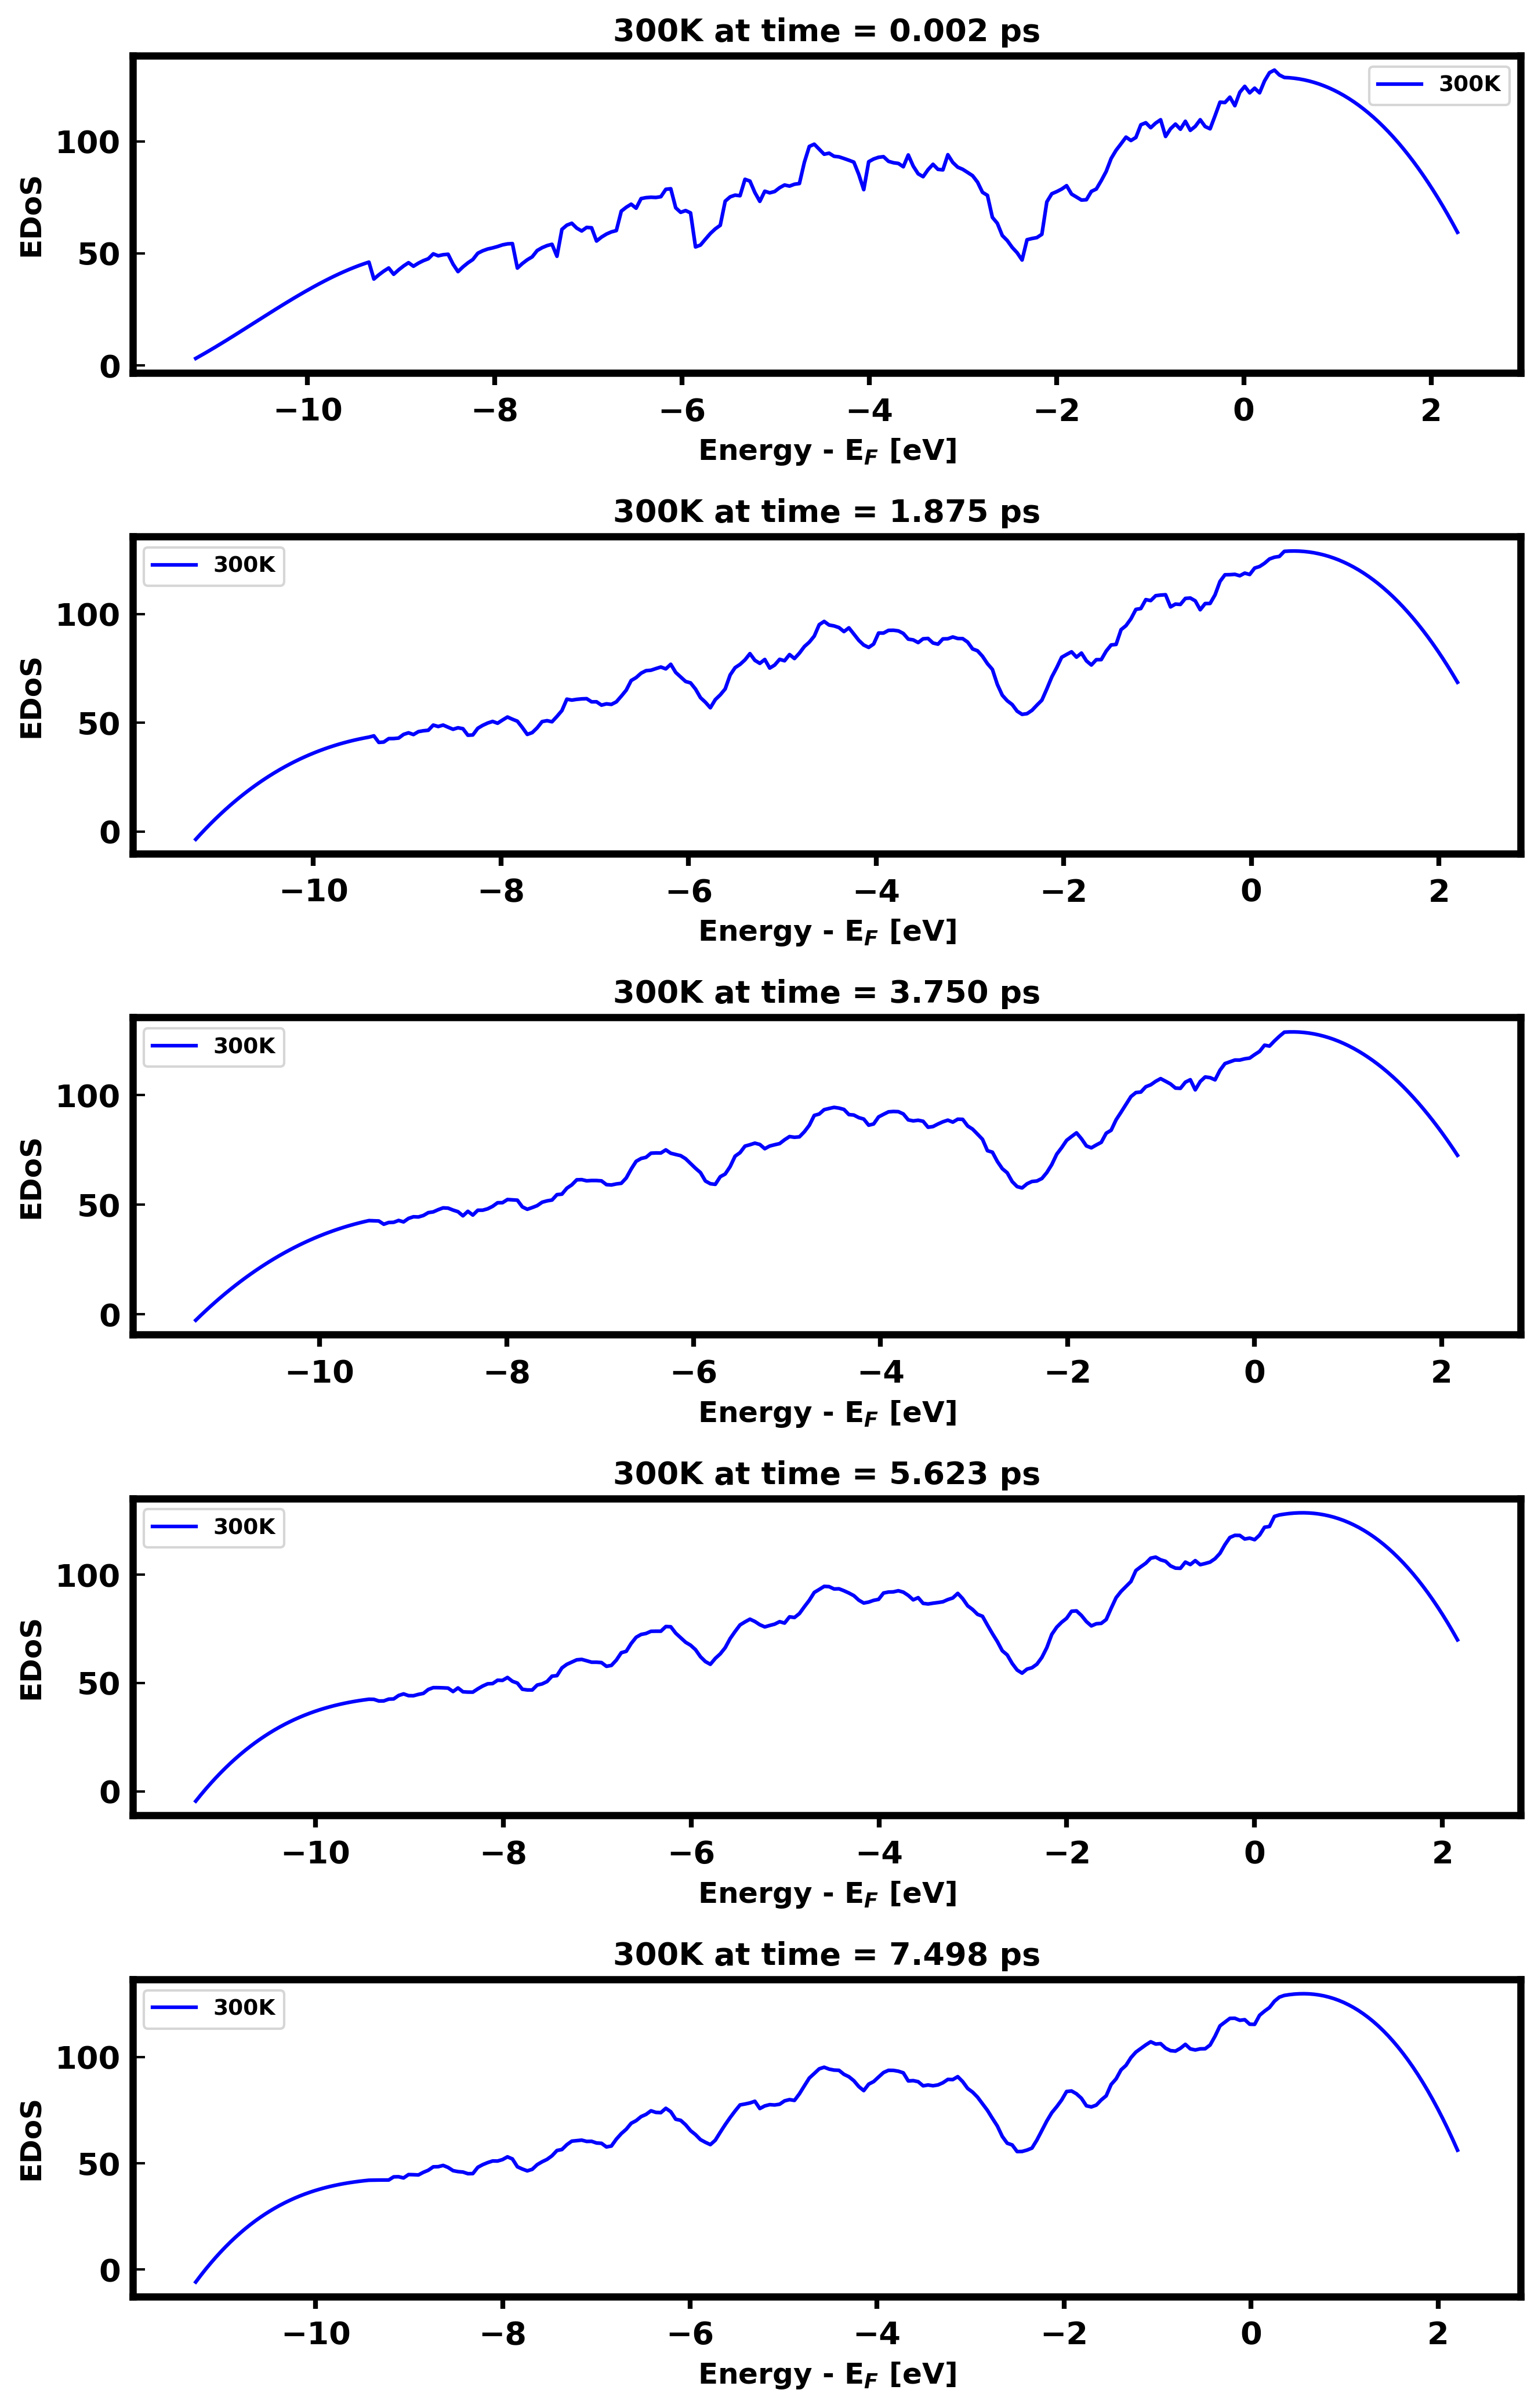


Saved figure as EDoS_300K_selected_times.png



In [18]:
# Plot 
fig, axs = plt.subplots(len(steps_to_plot), 1, figsize=(9, 2.8 * len(steps_to_plot)), dpi=300)
if len(steps_to_plot) == 1:
    axs = [axs]

for ax, step in zip(axs, steps_to_plot):
    indices = np.where(data[:, 0] == step)[0]
    energy = data[indices, 2]
    dos = data[indices, 3]
    dos_smooth = savgol_filter(dos, window_length=min(window, len(dos)//2*2-1), polyorder=poly)

    ax.plot(energy, dos_smooth, label=f"{label}", color='blue', lw=1.5)
    ax.set_xlabel("Energy - E$_F$ [eV]", fontsize=12)
    ax.set_ylabel("EDoS", fontsize=12)
    ax.set_title(f"{label} at time = {step * dt_ps:.3f} ps", fontsize=13)
    ax.legend(fontsize=9)
    # ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(f"EDoS_{label}_selected_times.png", bbox_inches='tight', dpi=300)
plt.show()
print(f"\nSaved figure as EDoS_{label}_selected_times.png\n")


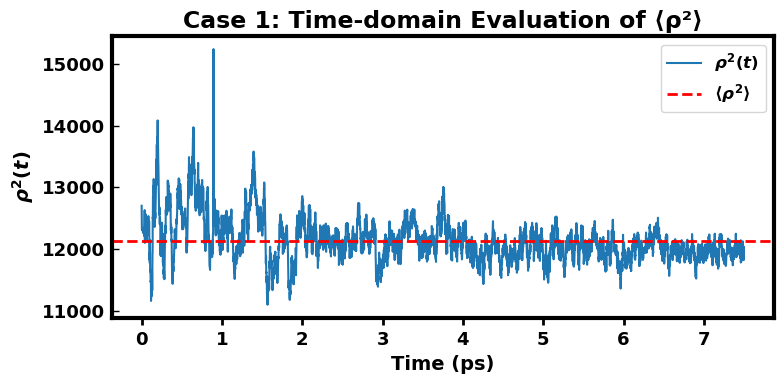

⟨ρ²⟩ = 12138.829407  (σ = 0.3 eV)


In [14]:
import numpy as np
import matplotlib.pyplot as plt

# === PARAMETERS ===
sigma = 0.3              # Width of Gaussian delta function (eV)
dt_ps = 0.0015           # Time step (ps)
data_file = "dos-time_python_300K.dat"  # Preprocessed from OUTCAR

# === Load preprocessed DOS data ===
data = np.loadtxt(data_file)  # Columns: [step, time(ps), energy - Ef, DOS]

# === Extract unique MD steps ===
steps = np.unique(data[:, 0]).astype(int)
step0 = steps[0]

rho_t_list = []
times = []

for step in steps:
    indices = np.where(data[:, 0] == step)[0]
    energy = data[indices, 2]  # E − E_F
    dos    = data[indices, 3]  # ρ(E, t)

    # === Gaussian δ centered at E = 0 ===
    g_sigma = (1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(- (energy**2) / (2 * sigma**2))

    # === ρ(t) = ∫ ρ(E, t) gσ(E) dE ≈ sum over bins
    rho_t = np.trapz(dos * g_sigma, energy)

    rho_t_list.append(rho_t)
    times.append((step - step0) * dt_ps)

# === Convert to arrays ===
rho_t_list = np.array(rho_t_list)
times = np.array(times)

# === ⟨ρ²⟩ = time average of [ρ(t)]²
rho_squared = rho_t_list**2
rho2_avg = np.mean(rho_squared)

# === Plot ρ²(t) and ⟨ρ²⟩ ===
plt.figure(figsize=(8, 4))
plt.plot(times, rho_squared, label=r"$\rho^2(t)$", lw=1.5)
plt.axhline(rho2_avg, color='red', linestyle='--', label=r"$\langle \rho^2 \rangle$")
plt.xlabel("Time (ps)")
plt.ylabel(r"$\rho^2(t)$")
plt.title("Case 1: Time-domain Evaluation of ⟨ρ²⟩")
plt.legend()
#plt.grid(True)
plt.tight_layout()
plt.show()

# ===  final result ===
print(f"⟨ρ²⟩ = {rho2_avg:.6f}  (σ = {sigma} eV)")


In [27]:
#PERSONAL PRACTICE OF THE BESSEL
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import i0  # Modified Bessel function I_0

# === PARAMETERS ===
sigma = 0.05              # Gaussian broadening width (eV)
Ef = 0.0                 # Fermi level (eV)
M = 5                    # Number of vibrational modes
n_bands = 3              # Number of eigenstates (i, j indices)

# === Static eigenvalues λ0 (band centers) ===
lambda0 = np.array([-0.05, 0.00, 0.07])  # centered around Ef

# === Amplitudes G_i,m for eigenvalue oscillations (small harmonic modulations) ===
# Shape: (n_bands, M)
np.random.seed(42)
G = 0.01 * np.random.rand(n_bands, M)  # small oscillations ~ 0.01 eV

# === Compute ⟨ρ²⟩ using Bessel-based formula (Eq. 23) ===
rho2_sum = 0.0

for i in range(n_bands):
    for j in range(n_bands):
        # Static energy part
        delta_i = lambda0[i] - Ef
        delta_j = lambda0[j] - Ef
        gauss_prefactor = (1 / (2 * np.pi * sigma**2)) * np.exp(-(delta_i**2 + delta_j**2) / (2 * sigma**2))

        # Product of Bessel functions over modes
        bessel_product = 1.0
        for m in range(M):
            arg = (G[i, m] * G[j, m]) / (sigma**2)
            bessel_product *= i0(arg)

        # Add to total
        rho2_sum += gauss_prefactor * bessel_product

rho2_sum


250.12765321507285

In [78]:
#USING THE DATA

In [75]:
import numpy as np
from scipy.fft import rfft
from scipy.special import i0

outcar_file = "OUTCAR_ALGB_300K"
sigma = 0.1        # Gaussian broadening width (eV)
Ef = 0.0           # Fermi level (can adjust if needed)
M = 5              # Number of FFT modes
band_range = (0, 159)  # 0-based band indices
skip_zero_freq = True  # Skip DC mode from FFT

# === Parse eigenvalues from OUTCAR ===
def parse_lambda_time_series(outcar, band_range):
    eigenvalues_dict = {i: [] for i in range(band_range[0], band_range[1]+1)}

    with open(outcar, 'r') as f:
        lines = f.readlines()

    nbands = None
    for line in lines:
        if 'NBANDS=' in line:
            nbands = int(line.split('NBANDS=')[1].split()[0])
            break
    if nbands is None:
        raise ValueError("NBANDS not found in OUTCAR")

    i = 0
    while i < len(lines):
        if 'E-fermi' in lines[i]:
            i += 8  # Skip to eigenvalue block
            band_counter = 0
            while band_counter < nbands and i < len(lines):
                line = lines[i].strip()
                tokens = line.split()
                if len(tokens) >= 2:
                    try:
                        band_id = band_counter
                        eig = float(tokens[1])
                        if band_id in eigenvalues_dict:
                            eigenvalues_dict[band_id].append(eig - Ef)
                        band_counter += 1
                    except ValueError:
                        pass  # Skip non-numeric lines
                i += 1
        else:
            i += 1

    return eigenvalues_dict

eigenvalues_dict = parse_lambda_time_series(outcar_file, band_range)
nbands = len(eigenvalues_dict)

# === Compute λ₀ and FFT amplitudes G_{i,m} ===
lambda0 = {i: np.mean(vals) for i, vals in eigenvalues_dict.items()}
G_dict = {}

for i, vals in eigenvalues_dict.items():
    fluctuations = np.array(vals) - lambda0[i]
    fft_vals = np.abs(rfft(fluctuations))
    fft_modes = fft_vals[1:M+1] if skip_zero_freq else fft_vals[:M]
    G_dict[i] = fft_modes

# === Final Bessel-based ⟨ρ²⟩ evaluation ===
rho2_sum = 0.0
for i in eigenvalues_dict:
    for j in eigenvalues_dict:
        delta_i = lambda0[i] - Ef
        delta_j = lambda0[j] - Ef
        prefactor = (1 / (2 * np.pi * sigma**2)) * np.exp(-(delta_i**2 + delta_j**2) / (2 * sigma**2))

        product = 1.0
        for m in range(M):
            Gi = G_dict[i][m]
            Gj = G_dict[j][m]
            product *= i0((Gi * Gj) / (sigma**2))

        rho2_sum += prefactor * product

print(f"⟨ρ²⟩ (Bessel-based) = {rho2_sum:.6f}  (σ = {sigma} eV, M = {M} modes)")


C:\Users\ridwa\AppData\Local\Temp\ipykernel_45104\2121083129.py:77: RuntimeWarning: invalid value encountered in scalar multiply
  rho2_sum += prefactor * product


⟨ρ²⟩ (Bessel-based) = nan  (σ = 0.1 eV, M = 5 modes)


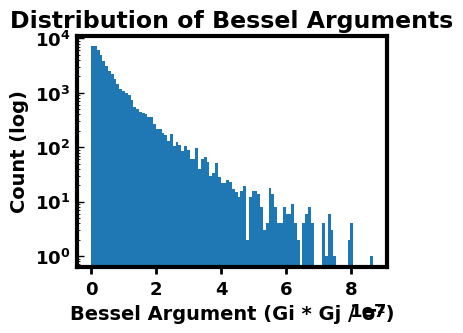

In [51]:
args = []
for i in eigenvalues_dict:
    for j in eigenvalues_dict:
        for m in range(M):
            Gi = G_dict[i][m] if m < len(G_dict[i]) else 0.0
            Gj = G_dict[j][m] if m < len(G_dict[j]) else 0.0
            arg = (Gi * Gj) / (sigma**2)
            args.append(arg)

plt.hist(args, bins=100, log=True)
plt.xlabel("Bessel Argument (Gi * Gj / σ²)")
plt.ylabel("Count (log)")
plt.title("Distribution of Bessel Arguments")
plt.show()


In [59]:
# === Final Bessel-based ⟨ρ²⟩ evaluation with stability(used clip) ===Just checking whether it works or not 
rho2_sum = 0.0
bessel_clip_max = 10  # To prevent overflow in i0()?? Iwould check whe am back

for i in eigenvalues_dict:
    for j in eigenvalues_dict:
        delta_i = lambda0[i] - Ef
        delta_j = lambda0[j] - Ef

        try:
            prefactor = (1 / (2 * np.pi * sigma**2)) * np.exp(-(delta_i**2 + delta_j**2) / (2 * sigma**2))
        except FloatingPointError:
            continue  # skip ill-defined

        product = 1.0
        for m in range(M):
            try:
                Gi = G_dict[i][m] if m < len(G_dict[i]) else 0.0
                Gj = G_dict[j][m] if m < len(G_dict[j]) else 0.0
                arg = (Gi * Gj) / (sigma**2)
                arg = np.clip(arg, 0, bessel_clip_max)  # clip to avoid overflow
                product *= i0(arg)
            except:
                product *= 1.0  # fallback: no contribution

        if np.isfinite(prefactor * product):
            rho2_sum += prefactor * product  # safe accumulation OK
        else:
            continue  # skip invalid pair Is it reasonable?

print(f"⟨ρ²⟩ (Bessel-based, safe) = {rho2_sum:.6f}  (σ = {sigma} eV, M = {M} modes)")


⟨ρ²⟩ (Bessel-based, safe) = 7174367436.176751  (σ = 0.01 eV, M = 2 modes)
